# TP2 Deep QLearning

Dans ce TP, vous devez implémenter un agent apprenant à faire atterir un vaisseau sur la lune avec l'algorithme Deep Q-Network. Pour cela vous allez utiliser [PyTorch](https://pytorch.org/) et [Gymnasium](https://gymnasium.farama.org/). 

<img src='img/lunarlander.png'  width=500px>

# 1. Consignes

> Vous devez  <span style="color:red">compléter ce notebook et les différents fichiers python associés</span>.  <span style="color:red"> Vous commenterez votre code</span> dans le notebook et dans les fichiers python.
> 
> Vous devez aussi rendre un <span style="color:red">rapport en pdf</span> (à ajouter à votre dépôt) avec le détail des différentes expérimentations réalisées dans les parties 6 et 7, i.e. pour chaque apprentissage testé, préciser dans le rapport les différents hyper paramètres (architecture du réseau, coefficient(s) d'apprentissage, nombre d'épisodes, taille du buffer, décroissance d'epsilon, ... tout ce qui permet de reproduire l'expérience) et mettre la courbe d'apprentissage obtenu.

> Le code doit être fonctionnel avec l'environnement virtuel du TP. Si d'autres packages que ceux présents dans l'environnement virtuel créé au départ sont nécessaires, vous devez ajouter à votre dépôt un fichier `environnement.yaml` qui est un export de votre environnement virtuel. Ce fichier est obtenu avec la commande suivante:  ```conda env export > environnement.yaml```



# 2. Import des packages

In [2]:
%load_ext autoreload
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 3. Gymnasium

En apprentissage par renforcement, il y a deux concepts fondamentaux : l’agent et l’environnement.
- L’agent est l’entité apprenante qui observe l’environnement et agit sur celui-ci selon les actions disponibles. Son objectif est de maximiser la récompense cumulée qu’il recoit de l’environnement avec lequel il interagit.
- L'agent interagit avec l'environnement à travers la boucle de perception/action ce qui nécessite de définir :
    - Un espace d’action.
    - Un espace d’état (ou observation).
    - Une fonction de récompense.
  
[Gymnasium](https://gymnasium.farama.org/) propose une interface open source unifiée entre un agent et un environnement.
- [Gymnasium](https://gymnasium.farama.org/) propose un ensemble d'environnements pour des tâches d'apprentissage par renforcement. La plupart des environnements ont leur code source disponible sur [GitHub](https://github.com/Farama-Foundation/Gymnasium/tree/main/gymnasium/envs). De nouveaux environnements peuvent aussi être créés à condition qu'ils soient compatibles avec l'interface. 
- Grâce à l'interface unifiée, il est possible de définir indépendamment un agent de l’environnement avec lequel il interagit (et inversement). 
- Lorsque certains pré-traitements sont nécessaires sur les actions, observations, récompenses, ... il est possible d’encapsuler l’environnement dans un **wrapper**, celui-ci se chargera du pré-traitement. 



Dans ce TP, nous allons implémenter un agent qui interagira avec l'environnement [LunarLander](https://gymnasium.farama.org/environments/box2d/lunar_lander/). Il existe plusieurs fonctions clé pour interagir avec un environnement.

>  <span style="color:green">Lisez la documentation de Gymnasium</span>: [utilisation basique](https://gymnasium.farama.org/content/basic_usage/), [API pour les environnements](https://gymnasium.farama.org/api/env/), ...




##  3.1 - Caractéristiques de l'environnement LunarLander-v2

> <span style="color:green">Compléter la cellule de code ci-dessous. A l'exécution devra s'afficher:
> 
> - **les dimensions pour les espaces d'états et d'actions** de l'environnement `LunarLander`.
> - les bornes min et max pour les dimensions de l'état
> - un échantillon pris au hasard dans chaque espace. 

In [3]:
env = gym.make("LunarLander-v2")
print("dimension de l'espace des observation : ", env.observation_space.shape[0])
print(" taille de l'espace des actions : ", env.action_space)
print("valeur minimale : ", env.observation_space.low)
print("valeur maximale : ", env.observation_space.high)
print("action au hasard : ", env.action_space.sample())
print("observation prise au hasard : ", env.observation_space.sample())



dimension de l'espace des observation :  8
 taille de l'espace des actions :  Discrete(4)
valeur minimale :  [-1.5       -1.5       -5.        -5.        -3.1415927 -5.
 -0.        -0.       ]
valeur maximale :  [1.5       1.5       5.        5.        3.1415927 5.        1.
 1.       ]
action au hasard :  0
observation prise au hasard :  [-1.0966628   1.0557717   0.8618711   1.9064031  -1.7002836  -3.5949779
  0.19324203  0.63072324]


## 3.2 Interaction et affichage de l'environnement sur un épisode

> <span style="color:green">Exécuter une instance de l'environnement `LunarLander` pendant un épisode avec des **actions aléatoires**. Afficher l'environnement à chaque pas pour visualiser le comportement du vaisseau. A la fin de l'épisode, afficher la somme des récompenses obtenues sur l'épisode et la raison pour laquelle l'épisode s'est terminé. </span>



In [4]:
env = gym.make("LunarLander-v2", render_mode="human")
observation, info = env.reset()
terminated = False
truncated = False 
total_reward = 0
while not (terminated or truncated): 
    action = env.action_space.sample()  # agent policy that uses the observation and info
    observation, reward, terminated, truncated, info = env.step(action)
    total_reward += reward

env.close()
if truncated : 
    print("L'épisode c'est fini prématurément soit car l'agent a pris trop de temps soit qu'il est sortis de l'espace d'observation")
else :
    print("l'épisode c'est fini car l'agent a atteint le sol")

print("récompense total : ", total_reward)

/Users/timothebonhoure/miniconda3/envs/tpdeeprl2023/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


l'épisode c'est fini car l'agent a atteint le sol
récompense total :  -129.81977040561284


# 4. Agent glouton (sans apprentissage)

> <span style="color:green">Vous devez maintenant implémenter un **agent glouton** qui utilise un réseau de neurones pour représenter la Q fonction.</span>

- définir l'architecture du réseau de neurones en complétant `QNN.py`. Ce réseau va approximer la Q-fonction comme dans DQN (pour l'instant, les poids du réseau ne seront pas mis à jour, le réseau est uniquement utilisé en prédiction).

- définir un agent glouton en complétant `agentglouton.py`: il utilisera la prédiction du réseau de neurones pour choisir ses actions selon une stratégie d’exploration $\epsilon$-greedy.

- utiliser cet agent sur plusieurs épisodes dans `LunarLander`. Vous utiliserez une décroissance de l'exploration, i.e. que $\epsilon$ va décroitre à chaque épisode, en démarrant à une valeur élevée (beaucoup d'exploration) et avec une borne minimum. Ainsi, au premier épisode, $\epsilon=\epsilon_{start}$, et à chaque épisode, $\epsilon=max(\epsilon_{end}, \epsilon_{decay}*\epsilon)$. Par exemple sur 1000 épisodes, les valeurs peuvent être $\epsilon_{start} = 1.0$, $\epsilon_{end} = 0.01$ et $\epsilon_{decay} = 0.995$.

- proposer un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser le fichier `utils.py`).


In [5]:
# import depuis un fichier python local 
%autoreload 2
from QNN import QNN 
%autoreload 2
from agentglouton import AgentGlouton
import utils

0
100
200
300
400
500
600
700
800
900
sum_rwd: <class 'list'>
avgs: <class 'list'>


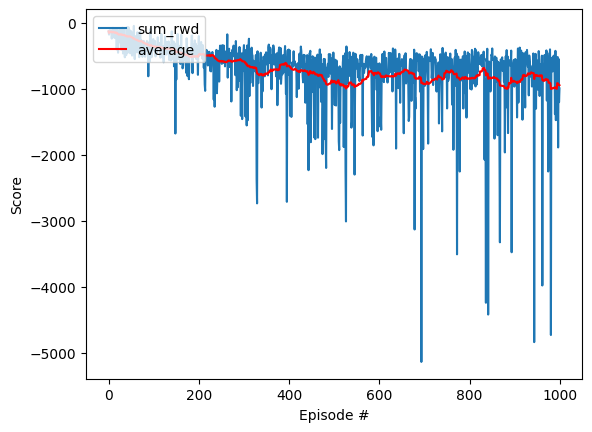

In [6]:
agent_glouton = AgentGlouton()

env = gym.make("LunarLander-v2")
eps_min = 0.01
eps_decay = 0.995
n_ep = 1_000
agent_glouton.eps = 1
rewards = []

def floating_average(n):
    return lambda list : [ sum(list[max(0,i-n):i+1])/ min(i+1,n) for i in range(len(list))]

def runOneEpisode():
    observation, info = env.reset()
    terminated = False
    truncated = False 
    total_reward = 0
    while not (terminated or truncated): 
        action = agent_glouton.getAction(observation)   # agent policy that uses the observation and info
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
    return total_reward

for i in range(n_ep):
    if i % 100 == 0 :
        print(i)
    rewards.append(runOneEpisode())
    agent_glouton.eps = max(agent_glouton.eps * eps_decay, eps_min)
utils.plot_sumrwd_mean_perepi(rewards,floating_average(50)(rewards))
env.close()

# 5. Experience replay

L'algorithme DQN utilise l’experience replay:
- pendant la phase de **sample**, qui est une phase d'interaction avec l'environnement sans apprentissage, l'agent stocke en mémoire toutes les interactions (ou expériences) rencontrées. Une interaction est un tuple `(état,action,état_suivant,récompense,fin_episode)`.  Le buffer a une taille maximale (100 000 par exemple). Lorsqu’elle est dépassée, les nouvelles interactions remplacent les plus anciennes. 

- pendant la phase d'**apprentissage**, l’agent apprend à partir des interactions stockées dans son buffer. Il choisit aléatoirement un minibatch d’interactions dans son buffer (64 par exemple).

> <span style="color:green">Compléter la classe `ReplayBuffer` du fichier `replaybuffer.py` pour stockez les interactions et récupérer des mini-batchs. </span> 


In [7]:
%autoreload 2
from replaybuffer import ReplayBuffer

# 6. Deep QLearning avec Replay Buffer


Vous allez maintenant implémenter l'algorithme du **Deep QLearning avec ReplayBuffer** pour que votre agent apprenne en mettant à jour les poids de son réseau de neurone. 

- Après chaque interaction, le buffer sera remplit. 
- Une phase d'apprentissage sera réalisée toutes les `n` interactions (par ex. $n=4$), pendant laquelle un minibatch de données sera choisi dans le buffer pour réaliser la descente de gradient. Pour une interaction $(s,a,s',r)$, la valeur cible (erreur TD) sera calculée de la façon suivante:
    - $y = r(s,a) + \gamma max_b Q_\omega(s',b) $ si l'épisode continu
    - $y = r(s,a)  $ si l'épisode se termine

Remarque: vous n'utiliserez pas de réseau cible (*target network*) pour l'instant.


> <span style="color:green">Compléter la classe `AgentDQN` et utiliser cet agent sur plusieurs épisodes dans `LunarLander`. Vous proposerez un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser `utils.py`), et une visualisation d'un épisode après apprentissage.</span> 
 
Pour l'optimizer, SGD et [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) sont particulièrement adaptés. 

Voici aussi des liens vers différentes fonctions de PyTorch qui pourraient vous être utiles:
- [unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html)
- [gather](https://pytorch.org/docs/stable/generated/torch.gather.html)
 
 

In [8]:
%autoreload 2
from agentdqn import AgentDQN

0


/Users/timothebonhoure/miniconda3/envs/tpdeeprl2023/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


100
200
300
400
500
600
700
800
900
sum_rwd: <class 'list'>
avgs: <class 'list'>


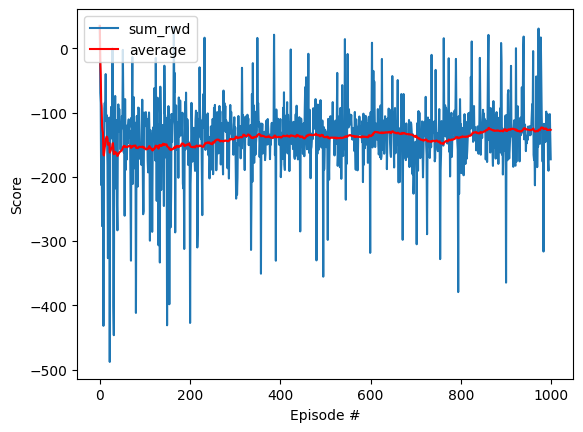

In [20]:

env = gym.make("LunarLander-v2")
agent_dqn = AgentDQN(env)
eps_min = 0.01
eps_decay = 0.995
n_ep = 1_000
rewards = []

for i in range(n_ep):
    if i % 100 == 0 :
        print(i)
    rewards.append(agent_dqn.runOneEpisode())

    agent_dqn.eps = max(agent_dqn.eps * eps_decay, eps_min)

utils.plot_sumrwd_mean_perepi(rewards,floating_average(100)(rewards))
env.close()

In [16]:
%autoreload 2
from test_agent import test_agent


In [21]:
    
agent_dqn.eps = 0
agent_glouton.eps = 0
print(test_agent(agent_dqn))
print(test_agent(agent_glouton))
print(test_agent(AgentDQN(gym.make("LunarLander-v2")))) #fully random choice

PicklingError: Can't pickle <class 'agentdqn.AgentDQN'>: it's not the same object as agentdqn.AgentDQN

# 7. Deep QLearning avec réseau cible

Il se peut que votre agent précédent apprenne des comportements intéressants mais qu’ils soient très instables. On va maintenant ajouter un réseau cible pour l'améliorer.

> <span style="color:green"> Compléter la classe `AgentDQNTarget` pour implémenter un agent apprenant avec DQN (deep QLearning et *target network*) pour stabiliser l’apprentissage. Utiliser cet agent sur plusieurs épisodes dans `LunarLander`. Vous proposerez un tracé de la somme des récompenses obtenues par épisode (vous pouvez utiliser `utils.py`), et une visualisation d'un épisode après apprentissage.</span> 
 
 
Pour la mise à jour du réseau cible, vous pouvez:
- toutes les N étapes d'apprentissage (10000 par exemple), recopier entièrement le réseau de neurone original dans le duplicat
- mettre à jour petit à petit le duplicat à chaque étape d’apprentissage : $$\omega' = (1-\tau)\omega' +\alpha \omega$$ où $\omega'$ sont les poids du duplicat, $\omega$ les poids du réseau original, et $\tau$ le pas de mise à jour. Souvent $\tau = 0.001$.


Pour copier des poids d'un réseau de neurone vers un autre, la méthode `copy_` peut être appelée sur les paramètres:

`for param_duplicat, param_source in zip(model_duplicat.parameters(), model_source.parameters()):`
           
`param_duplicat.data.copy_(param_source.data)`






In [ ]:
%autoreload 2
from agentdqntarget import AgentDQNTarget

0 1


/Users/timothebonhoure/miniconda3/envs/tpdeeprl2023/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


20 0.9607509570263429
40 0.9230424014270336
60 0.8868138705469162
80 0.8520072748321851
100 0.818566804688428
120 0.7864388409944025
140 0.7555718691280602


(raylet) [2023-09-28 17:06:17,803 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18291376128; capacity: 494384795648. Object creation will fail if spilling is required.


160 0.7259163963669665
180 0.697424872530677
200 0.670051613737823
220 0.6437527291556586
240 0.6184860506246193
260 0.5942110650450458
280 0.5708888494176704
300 0.5484820084336942


(raylet) [2023-09-28 17:06:27,893 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18290405376; capacity: 494384795648. Object creation will fail if spilling is required.


320 0.5269546145144024
340 0.5062721502041595
360 0.48640145282443054
380 0.46731066130007526
400 0.4489691650726603
420 0.4313475550188765
440 0.41441757629535864
460 0.3981520830343033


(raylet) [2023-09-28 17:06:37,986 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18290401280; capacity: 494384795648. Object creation will fail if spilling is required.


480 0.38252499481723873
500 0.36751125485715885
520 0.35308678982196745
540 0.3392284712348143
560 0.32591407838943093
580 0.31312226272100424
600 0.3008325135754587


(raylet) [2023-09-28 17:06:48,078 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18290401280; capacity: 494384795648. Object creation will fail if spilling is required.


620 0.2890251253222622
640 0.27768116575802215
660 0.2667824457502102


(raylet) [2023-09-28 17:06:58,165 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18290053120; capacity: 494384795648. Object creation will fail if spilling is required.


680 0.2563114900723428
700 0.24625150938385126


(raylet) [2023-09-28 17:07:08,262 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18288885760; capacity: 494384795648. Object creation will fail if spilling is required.


720 0.23658637330971655
740 0.22730058457670177
760 0.21837925416471335


(raylet) [2023-09-28 17:07:18,350 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18287742976; capacity: 494384795648. Object creation will fail if spilling is required.


780 0.2098080774334473
800 0.20157331118604155
820 0.1936617516329582


(raylet) [2023-09-28 17:07:28,440 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18287656960; capacity: 494384795648. Object creation will fail if spilling is required.


840 0.1860607132207625
860 0.17875800829185146


(raylet) [2023-09-28 17:07:38,533 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18287652864; capacity: 494384795648. Object creation will fail if spilling is required.


880 0.17174192754251918
900 0.1650012212480241
920 0.15852508122455447
940 0.15230312349916944


(raylet) [2023-09-28 17:07:48,625 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18287644672; capacity: 494384795648. Object creation will fail if spilling is required.


960 0.14632537165992823
980 0.14058224085951135


(raylet) [2023-09-28 17:07:58,719 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18287620096; capacity: 494384795648. Object creation will fail if spilling is required.


1000 0.13506452244668335
1020 0.12976336920095705


(raylet) [2023-09-28 17:08:08,807 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18286587904; capacity: 494384795648. Object creation will fail if spilling is required.


1040 0.12467028114678214
1060 0.11977709192451416


(raylet) [2023-09-28 17:08:18,897 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18286587904; capacity: 494384795648. Object creation will fail if spilling is required.


1080 0.11507595569630924
1100 0.11055933456595012


(raylet) [2023-09-28 17:08:28,990 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18286583808; capacity: 494384795648. Object creation will fail if spilling is required.


1120 0.10621998649243217
1140 0.10205095367792938


(raylet) [2023-09-28 17:08:39,079 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18290700288; capacity: 494384795648. Object creation will fail if spilling is required.


1160 0.09804555141152164
1180 0.0941973573507949
1200 0.09050020122412858


(raylet) [2023-09-28 17:08:49,169 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18290700288; capacity: 494384795648. Object creation will fail if spilling is required.


1220 0.08694815493715811
1240 0.08353552306754937
1260 0.08025683373284419


(raylet) [2023-09-28 17:08:59,258 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18290245632; capacity: 494384795648. Object creation will fail if spilling is required.


1280 0.07710682981673408
1300 0.07408046053969458
1320 0.07117287336046382
1340 0.06837940619538035


(raylet) [2023-09-28 17:09:09,347 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18290241536; capacity: 494384795648. Object creation will fail if spilling is required.


1360 0.06569557994310468
1380 0.06311709130273843


(raylet) [2023-09-28 17:09:19,437 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18290257920; capacity: 494384795648. Object creation will fail if spilling is required.


1400 0.06063980587382501


(raylet) [2023-09-28 17:09:29,525 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18289106944; capacity: 494384795648. Object creation will fail if spilling is required.


1420 0.05825975152716902


(raylet) [2023-09-28 17:09:39,617 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18289106944; capacity: 494384795648. Object creation will fail if spilling is required.


1440 0.055973112035844576


(raylet) [2023-09-28 17:09:49,708 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18289111040; capacity: 494384795648. Object creation will fail if spilling is required.


1460 0.053776220956180384
1480 0.05166555574891037
1500 0.0496377321310635


(raylet) [2023-09-28 17:09:59,796 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18288734208; capacity: 494384795648. Object creation will fail if spilling is required.


1520 0.04768949864953651


(raylet) [2023-09-28 17:10:09,887 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18288726016; capacity: 494384795648. Object creation will fail if spilling is required.


1540 0.045817731467648684
1560 0.044019429356319445
1580 0.04229170888183738


(raylet) [2023-09-28 17:10:19,969 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18288726016; capacity: 494384795648. Object creation will fail if spilling is required.


1600 0.04063179978250474
1620 0.039037040526744164


(raylet) [2023-09-28 17:10:30,056 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18288508928; capacity: 494384795648. Object creation will fail if spilling is required.


1640 0.037504874045545575
1660 0.03603284363241035


(raylet) [2023-09-28 17:10:40,148 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18288443392; capacity: 494384795648. Object creation will fail if spilling is required.


1680 0.034618589004218825
1700 0.033259842516704864
1720 0.03195442552846963
1740 0.030700244907704188
1760 0.0294952896760199
1780 0.02833762778400533
1800 0.0272254030133394
1820 0.026156832000493707


(raylet) [2023-09-28 17:10:50,240 E 16553 7424559] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2023-09-28_16-24-44_905214_10515 is over 95% full, available space: 18288435200; capacity: 494384795648. Object creation will fail if spilling is required.


1840 0.0251302013772516
1860 0.024143865023459197
1880 0.023196241427603265
1900 0.022285811150983933
1920 0.021411114391416148
1940 0.020570748642553566
1960 0.019763366445081684
1980 0.018987673226174544
sum_rwd: <class 'list'>
avgs: <class 'list'>


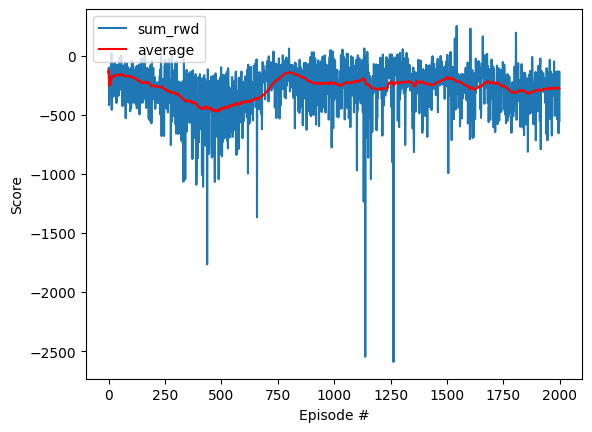

In [ ]:
env = gym.make("LunarLander-v2")
agent_dqn_target = AgentDQNTarget(env)
eps_min = 0.01
eps_decay = 0.998
n_ep = 2_000
rewards = []
state_memory = []

def save_current_state():
    state_memory.append(agent_dqn_target.QNN.state_dict())

for i in range(n_ep):
    if i % (n_ep / 100) == 0 :
        save_current_state()
        print(i,agent_dqn_target.eps)
    rewards.append(agent_dqn_target.runOneEpisode())

    agent_dqn_target.eps = max(agent_dqn_target.eps * eps_decay, eps_min)

utils.plot_sumrwd_mean_perepi(rewards,floating_average(100)(rewards))
env.close()



In [80]:
def test_agent_stored_in_state_dict(agent, state_memory, mean = True, visual = True):
    performances = []
    agent.eps=0
    for state_dict in state_memory :
        agent.QNN.load_state_dict(state_dict)
        performances.append(test_agent(agent, mean= mean, visual= visual))
    return performances

utils.plot_sumrwdperepi(test_agent_stored_in_state_dict(agent_dqn_target,state_memory))

PicklingError: Can't pickle <class 'agentdqntarget.AgentDQNTarget'>: it's not the same object as agentdqntarget.AgentDQNTarget

In [49]:
agent_dqn_target.eps = 0
print(test_agent(agent_dqn_target))

0
100
200
300
400
500
600
700
800
900
-499.7076875360375


In [ ]:
#TODO corrige
import utils
from QNNC import QNNC
from replaybufferC import ReplayBufferC
from agentdqnC import AgentDQNC
from agentdqntargetC import AgentDQNTargetC
import gymnasium as gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
#Correction
env = gym.make("LunarLander-v2")#a remettre sinon erreur ...
wrapped_env = gym.wrappers.RecordEpisodeStatistics(env, 50)  # Records episode reward/length, 50= taille du buffer

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

eps_start = 1.0
eps_end = 0.01
eps_decay = 0.995

dqlagent = AgentDQNTargetC(state_size,action_size,gamma=0.99)
print(dqlagent.qnetwork_local)

nb_episodes = 1000
dqlalgo(dqlagent,wrapped_env,nb_episodes,eps_start,eps_end,eps_decay)

### sauvegarde reseau

In [ ]:
#sauvegarde du réseau 
savedfile = 'checkpoint_DQNtarget_3232.pth'
torch.save(dqlagent.qnetwork_local.state_dict(), savedfile)

In [ ]:
#TODO: verif que fonctionne 
state_dict = torch.load(savedfile)
print(state_dict.keys())
dqlagentb = DQLAgentC(state_size,action_size,gamma=0.99)
dqlagentb.qnetwork.load_state_dict(state_dict)
print(dqlagentb.qnetwork)

#dqlalgo(dqlagent,50,eps_start,eps_end,eps_decay,True)

### voir politique apprise

In [ ]:
env = gym.make("LunarLander-v2", render_mode="human")#a remettre sinon erreur ...
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
savedfile = 'checkpoint_DQNtarget_3232.pth'
state_dict = torch.load(savedfile)
dqlagentb = DQLAgentTargetC(state_size,action_size,gamma=0.99)
dqlagentb.qnetwork_local.load_state_dict(state_dict)
eps_start = 0.01
eps_end = 0.01
eps_decay = 0.995
nb_episodes = 1
dqlalgo(dqlagentb,env,nb_episodes,eps_start,eps_end,eps_decay)